# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Analysis PLan 

Cross-Industry Standard Process of Data Mining - (CRISP-DM)

A. Bussiness Understanding                 
    1. Formulate research/analysis question(s)
B. Data Understanding
    1. Seek for relevant datasets
    2. Read/Download relevant datasets
C. Data preparation
    1. Examine and understand the datasets
    2. Clean and join datasets
    3. Features extraction and engineering
    4. Exploratory and explanatory data analysis
    5. Data visualization
D. Predictive modeling and answers to research question
    1. Tackle reseach questions
    2. Supervised learning
E. Deployment
    1. Summary report
    2. Conclusion(s)

# A. Bussiness Understanding                 
    1. Formulate research/analysis question(s)
    
           Question I
                Who is the typical Starbucks rewards mobile app user?
                        Analysis of descriptive statistics of all variables in the dataset.
                        
            Question II
                 Which demographic group respond best to which offer type?
                        Analyzing the response rate of each gender and age groups.

                        
            Question III
                Who will response to an offer?
                        Build machine learning model that predicts whether or not someone will respond to an offer.

# B. Data Understanding
    1. Seek for relevant datasets
    2. Read/Download relevant datasets

### import modules and libraries

In [1]:
!pip install pandas xgboost eli5 --upgrade

Requirement already up-to-date: pandas in /opt/conda/lib/python3.6/site-packages (1.0.3)
Requirement already up-to-date: xgboost in /opt/conda/lib/python3.6/site-packages (1.0.2)
Requirement already up-to-date: eli5 in /opt/conda/lib/python3.6/site-packages (0.10.1)


In [2]:
import numpy as np
import pandas as pd
import math
import json
import datetime as dt

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MaxAbsScaler


from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report


from eli5.sklearn import PermutationImportance


% matplotlib inline

bcolor = sns.color_palette()[0]
blued = sns.color_palette("Blues_d")

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of n

# C. Data preparation
    1. Examine and understand the datasets
    2. Clean and join datasets
    3. Features extraction and engineering
    4. Exploratory and explanatory data analysis
    5. Data visualization

#### 1. Examine and understand the datasets

In [3]:
def exam_understand(dataset):
    """The exam_understand function print out the head, information (dtype, non-missing number, column name),
        shape and descriptive statistics for numerical features of dataset
    
    Args:
        dataset (DataFrame)
        
    Outputs:
        
    
    """
    
    sp = {"sep":"\n\n\n", "end":"\n\n\n"}
    
    print(dataset.describe(),  **sp)
    print(" ", **sp)
    print(dataset.info(), dataset.shape, **sp)


    

In [4]:
exam_understand(portfolio)

          reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000


 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes
None


(10, 6)




In [5]:
exam_understand(profile)


                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000


 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None


(17000, 5

In [6]:
exam_understand(transcript)

                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000


 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None


(306534, 4)




In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [8]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [9]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [11]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

## 2a. Clean
## 3. Features extraction and engineering

In [12]:
def clean_transact(datta):
    """The clean_transact function will do data cleaning and wrangling of the transaction data 
     
     Input:
         data (DataFrame) : The dataset for cleaning
         
         
     Output:
         
         clean_dat (DataFrame) : cleaned dataset
    
    
    """
    
    # make copy of the data
    data = datta.copy()
    
    # extract the values from the rewards if the exist on the value column's dictionary
    #  if don't exist replace with 99999
    data['offer_id_rewards'] = data['value'].apply(lambda x: list(x.values())[1] if len(list(x.values())) > 1 else 99999)
    

    # extract the 'offer ids','offer_id', and 'amount' keywords from the value column's dictionary and convert to string dtype
    data['offer_id_keys'] = data['value'].apply(lambda x: list(x.keys())[0]).astype(str)
    
    # extract the offer values of the value column's dictionary
    # these are the offer ids and rewards amounts respectively where they exist
    data['offer_id_values'] = data['value'].apply(lambda x: list(x.values())[0])
    
    
    # extract offer ids if there is an offer or replace with no_offer is there is not offer made to user
    data["offer_id"] = data[["offer_id_values", "offer_id_keys"]].apply(lambda x: x[0] if x[1] !="amount" else "no_offer" , axis=1)
    
    
    # extract the offer amount is there was an offer or replace with 9999 if not offer was made to user
    data["reward_amt"] = data[["offer_id_values", "offer_id_keys"]].apply(lambda x: x[0] if x[1] =="amount" else 9999 , axis=1)
    
    
    # drop columns not essential for further analysis
    data.drop(columns=["value", "offer_id_keys", "offer_id_keys"], inplace=True)
    
    return data


In [13]:
def profile_cleaner(dat):
    """The profile_cleaner function will do data cleaning and wrangling of the profile data 
     
     Input:
         dat (DataFrame) : The dataset for cleaning
         
         
     Output:
         
         profile2 (DataFrame) : cleaned dataset
         
    
    """
    
    # make copy of the data
    profile2 = dat.copy()
    
    # convert become_member_on column to datetime dtype
    profile2["membershipDate"] = pd.to_datetime(profile2["became_member_on"], format="%Y%m%d")
    
    # get the most recent member membership start date
    ## add 1 day to it, to get a reference date => refDate
    refDate = profile2.membershipDate.max().date() + dt.timedelta(days=1)
    
    # calculate days since joining, using the refDate
    profile2["membershipDays"] = profile2["membershipDate"].apply(lambda x : (refDate - x.date()).days)
    
    # get income groups
    #     Lowest income less than 31,000
    #     Lower-middle income between 31,000  and 41,999
    #     Middle-income between 42,000 and 125,999
    #     Upper-middle income between 126,000 and 187,999
    #     Higher-income more than 188,000 
    
    # sorted bar chart on ordinal categories
    ordering_i = ["Lowest", "Lower-middle", "Middle-income","Upper-middle", "Higher-income"]
    ti = pd.api.types.CategoricalDtype(categories= ordering_i, ordered=True)

    profile2["incomegroups"] = pd.cut(profile2.income, bins=[0,30999,42000,126000, 188000, 1000000],
                                   labels=ordering_i, right=False).astype(ti)
                  
                  
    # categorise age to get agegroups
    #     - Elder Adults (over 70 years old)
    #     - Baby Boomers (Roughly 51 to 70 years old)
    #     - Generation X (Roughly 35 – 50 years old)
    #     - Millennials, or Generation Y (18 – 34 years old)
    #     - Generation Z, or iGeneration (Teens & younger)
                  
    ordering_a = [ "millennials", "genX", "babyboomer","elderlyadult"]
    ta = pd.api.types.CategoricalDtype(categories= ordering_a, ordered=True)
    
    profile2["agegroups"] = pd.cut(profile2.age, bins=[profile2.age.min(),35,51,71, profile2.age.max()+1],
                                   labels=ordering_a, right=False).astype(ta)
    
    
    # drop become_member_on column 
    profile2.drop(columns=["became_member_on"], inplace=True)
    
    return profile2
    
    

In [14]:
def clean_portfolio(datapp):
    """The clean_portfolio function will do data cleaning and wrangling of the portfolio data 
     
     Input:
         datapp (DataFrame) : The dataset for cleaning
         
         
     Output:
         
         vectdata (DataFrame) : cleaned dataset
    
    
    """
    
    # make copy of the data
    datap = datapp.copy()
    
    # get ids
    bbb = datap.id.tolist()
    
    # create offerType2
    # datap['offerType2'] = datap[['offer_type', 'id']].apply(lambda x: x[0]+str(bbb.index(x[1])), axis=1)
    datap['offer_id_short'] = [str(x).strip()[-4:] for x in datap['id']]
    datap['offerType2'] = datap[['offer_type', 'offer_id_short']].agg('-'.join, axis=1)
    
    
    # initialize countervectorizer
    countVectorizer = CountVectorizer()
    
    # tranform channels column content list to text
    datap['ch'] = datap['channels'].apply(lambda x: " ".join(word for word in x))
    
    # Fit and  Transform the texts
    content_vectorized = countVectorizer.fit_transform(datap['ch'])

    # convert to array
    content_Varray = content_vectorized.toarray()


    # convert to dataframe
    content_df = pd.DataFrame(content_Varray, 
                         columns=countVectorizer.get_feature_names()).add_prefix('Channel_')

    # concat the dataframes
    vectdata = pd.concat([datap, content_df], axis=1)
    

    # drop channels and ch columns
    vectdata.drop(columns=['channels', 'ch'], inplace=True)
    
    return vectdata


## 2b.  Join datasets

In [15]:
def data_merger(data1, data22, data33):
    """The data_merger function will merge the datasets
    
    Inputs:
        data1 (DataFrame)
        data22 (DataFrame)
        data33 (DataFrame)
        
    
    Output:
        data4 (DataFrame) : Merged dataset
        
    
    """
    
    # clean raw  datasets
    # clean transcripts dataset
    data1_clean = clean_transact(data1)
    
    # clean profile dataset
    data2 = profile_cleaner(data22)
    
    #     # clean portfolio dataset
    data3 = clean_portfolio(data33)
   
    # update the id column name to p_id
    # profile had a column named id
    # this will give error on merging the datasets
    data3.rename(columns = {'id':'p_id'}, inplace = True) 
    
    
    # merge cleaned trascript and profile datasets
    data4 = pd.merge(data1_clean, data2, how="outer", left_on ="person", right_on="id")
    
    # merge data4 with cleaned portfolio dataset
    data5 = pd.merge(data4, data3, how="outer", left_on ="offer_id", right_on="p_id")
    
    
    # drop duplicate columns
    data5.drop(columns=["offer_id_values", "id", "p_id"], inplace=True)
    
    return data5


In [16]:
clean_data = data_merger(transcript, profile, portfolio)

In [17]:
clean_data.head()

,person,event,time,offer_id_rewards,offer_id,reward_amt,gender,age,income,membershipDate,...,reward,difficulty,duration,offer_type,offer_id_short,offerType2,Channel_email,Channel_mobile,Channel_social,Channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,F,75,100000.0,2017-05-09,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,F,75,100000.0,2017-05-09,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,F,75,100000.0,2017-05-09,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
3,e2127556f4f64592b11af22de27a7932,offer received,408,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,M,68,70000.0,2018-04-26,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,M,68,70000.0,2018-04-26,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0


In [18]:
exam_understand(clean_data)

                time  offer_id_rewards     reward_amt            age  \
count  306534.000000     306534.000000  306534.000000  306534.000000   
mean      366.382940      89045.233876    5472.208208      60.909367   
std       200.326314      31230.275860    4971.338070      26.032030   
min         0.000000          2.000000       0.050000      18.000000   
25%       186.000000      99999.000000      10.770000      43.000000   
50%       408.000000      99999.000000    9999.000000      57.000000   
75%       528.000000      99999.000000    9999.000000      72.000000   
max       714.000000      99999.000000    9999.000000     118.000000   

              income  membershipDays        reward     difficulty  \
count  272762.000000   306534.000000  167581.00000  167581.000000   
mean    64337.000755      575.943011       4.41991       7.850401   
std     21243.762941      421.482784       3.37336       5.048944   
min     30000.000000        1.000000       0.00000       0.000000   
25%   

In [19]:
clean_data.shape

(306534, 23)

In [20]:
clean_data.agegroups.value_counts()

babyboomer      117015
elderlyadult     80795
genX             64408
millennials      44316
Name: agegroups, dtype: int64


**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# 3. Exploratory and explanatory data analysis

## 3a.  Missing data analysis

In [21]:
# analyse missing gender
missing_gender = clean_data[clean_data['gender'].isna()]
missing_gender.event.value_counts()

transaction        14996
offer received      9776
offer viewed        7865
offer completed     1135
Name: event, dtype: int64

In [22]:
missing_gender.head()

,person,event,time,offer_id_rewards,offer_id,reward_amt,gender,age,income,membershipDate,...,reward,difficulty,duration,offer_type,offer_id_short,offerType2,Channel_email,Channel_mobile,Channel_social,Channel_web
6,68617ca6246f4fbc85e91a2a49552598,offer received,504,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,None,118,NaN,2017-10-02,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
7,68617ca6246f4fbc85e91a2a49552598,offer viewed,648,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,None,118,NaN,2017-10-02,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
17,65aba5c617294649aeb624da249e1ee5,offer received,168,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,None,118,NaN,2017-03-30,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
18,65aba5c617294649aeb624da249e1ee5,offer viewed,174,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,None,118,NaN,2017-03-30,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
75,5e9c83e8ab4d4e9ca83f3256d83ca756,offer received,504,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,None,118,NaN,2016-01-30,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0


In [23]:
missing_gender.shape, missing_gender.person.nunique()

((33772, 23), 2175)

In [24]:
# analyse missing income
missing_income = clean_data[clean_data['income'].isna()]
missing_income.event.value_counts()

transaction        14996
offer received      9776
offer viewed        7865
offer completed     1135
Name: event, dtype: int64

In [25]:
missing_income.shape, missing_income.person.nunique()

((33772, 23), 2175)

In [26]:
# analyse missing gender among those missing income
missing_income_gender = missing_income[missing_income['gender'].isna()]
missing_income_gender.event.value_counts()

transaction        14996
offer received      9776
offer viewed        7865
offer completed     1135
Name: event, dtype: int64

In [27]:
missing_income_nodup = missing_income.drop_duplicates(subset=['person'])
missing_income_nodup.shape

(2175, 23)

In [28]:
missing_income_nodup.event.value_counts()

transaction       1303
offer received     872
Name: event, dtype: int64

In [29]:
# analyse none missing gender among those missing income
missing_income_gender_npg = missing_income[~missing_income['gender'].isna()]
missing_income_gender_npg.shape

(0, 23)

In [30]:
# analyse age amongst those missing gender and income
missing_income.age.describe()

count    33772.0
mean       118.0
std          0.0
min        118.0
25%        118.0
50%        118.0
75%        118.0
max        118.0
Name: age, dtype: float64

In [31]:
nullreward = clean_data[clean_data.reward.isnull()]
nullreward.head()

,person,event,time,offer_id_rewards,offer_id,reward_amt,gender,age,income,membershipDate,...,reward,difficulty,duration,offer_type,offer_id_short,offerType2,Channel_email,Channel_mobile,Channel_social,Channel_web
16202,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,99999,no_offer,19.89,F,75,100000.0,2017-05-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16203,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,99999,no_offer,17.78,F,75,100000.0,2017-05-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16204,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,99999,no_offer,19.67,F,75,100000.0,2017-05-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16205,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,99999,no_offer,29.72,F,75,100000.0,2017-05-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16206,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,99999,no_offer,23.93,F,75,100000.0,2017-05-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
nullreward.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138953 entries, 16202 to 155154
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   person            138953 non-null  object        
 1   event             138953 non-null  object        
 2   time              138953 non-null  int64         
 3   offer_id_rewards  138953 non-null  int64         
 4   offer_id          138953 non-null  object        
 5   reward_amt        138953 non-null  float64       
 6   gender            123957 non-null  object        
 7   age               138953 non-null  int64         
 8   income            123957 non-null  float64       
 9   membershipDate    138953 non-null  datetime64[ns]
 10  membershipDays    138953 non-null  int64         
 11  incomegroups      123957 non-null  category      
 12  agegroups         138953 non-null  category      
 13  reward            0 non-null       float64       
 14  

In [33]:
nullreward.event.value_counts()

transaction    138953
Name: event, dtype: int64

## insights

- From the analysis above, members missing gender data also had missing income data.
- Looking carefully at the age for members with missing gender and income data, the mean, max, median, 25% and 75% percentiles are the same, 118 years with standard deviation of 0.0. Therefore,
     - Apart from the age of 118 years being questionable; all 2172 user had the same age, 118 years.
     - Also, many of those missing gender and income data were transaction (1303) with few receiving an offer (872) but none of them ever viewed or completed the offer.
     - I can conclude that the missing entries in the data is not random.
     - I can conclude that those missing income, age and gender data wouldn't contribute much information toward our analysis.
- Missing reward, difficulty, duration, offer_type, offerType2, Channel_email, Channel_mobile, Channel_social, Channel_web are associated with features of offer. Therefore, they are missing if user didn't receive an offer. Also, for user with missing data on these variable, the event recorded is only transaction, confirming that those user didn't receive any offer.
        
- Based on the above analysis, it seem reasonable to drop missing gender and age data from further analysis

## 3b. Working with complete, non-missing dataset

In [34]:
data = clean_data[~clean_data['gender'].isna()]
data.event.value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306533
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   person            272762 non-null  object        
 1   event             272762 non-null  object        
 2   time              272762 non-null  int64         
 3   offer_id_rewards  272762 non-null  int64         
 4   offer_id          272762 non-null  object        
 5   reward_amt        272762 non-null  float64       
 6   gender            272762 non-null  object        
 7   age               272762 non-null  int64         
 8   income            272762 non-null  float64       
 9   membershipDate    272762 non-null  datetime64[ns]
 10  membershipDays    272762 non-null  int64         
 11  incomegroups      272762 non-null  category      
 12  agegroups         272762 non-null  category      
 13  reward            148805 non-null  float64       
 14  diff

In [36]:
data.person.nunique()

14825

In [37]:
data = data.fillna({'reward': 99 ,'difficulty':99, 'offer_type':'No_offer', 
                    'offerType2':'No_offer','duration':0, 'Channel_web':0,
                    'Channel_email':0, 'Channel_mobile':0, 'Channel_social':0})

# data = data.fillna(0, inplace = True)

In [38]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306533
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   person            272762 non-null  object        
 1   event             272762 non-null  object        
 2   time              272762 non-null  int64         
 3   offer_id_rewards  272762 non-null  int64         
 4   offer_id          272762 non-null  object        
 5   reward_amt        272762 non-null  float64       
 6   gender            272762 non-null  object        
 7   age               272762 non-null  int64         
 8   income            272762 non-null  float64       
 9   membershipDate    272762 non-null  datetime64[ns]
 10  membershipDays    272762 non-null  int64         
 11  incomegroups      272762 non-null  category      
 12  agegroups         272762 non-null  category      
 13  reward            272762 non-null  float64       
 14  diff

In [39]:
data.head()

,person,event,time,offer_id_rewards,offer_id,reward_amt,gender,age,income,membershipDate,...,reward,difficulty,duration,offer_type,offer_id_short,offerType2,Channel_email,Channel_mobile,Channel_social,Channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,F,75,100000.0,2017-05-09,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,F,75,100000.0,2017-05-09,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,F,75,100000.0,2017-05-09,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
3,e2127556f4f64592b11af22de27a7932,offer received,408,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,M,68,70000.0,2018-04-26,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,M,68,70000.0,2018-04-26,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0


In [40]:
data[data.event == "transaction"].tail()

,person,event,time,offer_id_rewards,offer_id,reward_amt,gender,age,income,membershipDate,...,reward,difficulty,duration,offer_type,offer_id_short,offerType2,Channel_email,Channel_mobile,Channel_social,Channel_web
155147,47683732768a4f7db7abb710ca22e66e,transaction,684,99999,no_offer,7.10,M,24,56000.0,2017-11-08,...,99.0,99.0,0.0,No_offer,NaN,No_offer,0.0,0.0,0.0,0.0
155148,3873fe915496482eb589fa316ae7b0db,transaction,510,99999,no_offer,1.57,M,58,57000.0,2017-09-05,...,99.0,99.0,0.0,No_offer,NaN,No_offer,0.0,0.0,0.0,0.0
155149,3873fe915496482eb589fa316ae7b0db,transaction,588,99999,no_offer,1.21,M,58,57000.0,2017-09-05,...,99.0,99.0,0.0,No_offer,NaN,No_offer,0.0,0.0,0.0,0.0
155150,3873fe915496482eb589fa316ae7b0db,transaction,612,99999,no_offer,2.65,M,58,57000.0,2017-09-05,...,99.0,99.0,0.0,No_offer,NaN,No_offer,0.0,0.0,0.0,0.0
155151,8578196a074a4f328976e334fa9383a3,transaction,702,99999,no_offer,4.62,M,48,58000.0,2018-06-10,...,99.0,99.0,0.0,No_offer,NaN,No_offer,0.0,0.0,0.0,0.0


In [41]:
data.shape, data.person.nunique()

((272762, 23), 14825)

In [42]:
data['gender'].value_counts()

M    155690
F    113101
O      3971
Name: gender, dtype: int64

In [43]:
def col_encoder(data, x):
    """The col_encoder function maps the long string column values to simple number string
    
    Input:
        data (DataFrame): the dataframe to encode
        x (string): column to recode
        
        
    Output:
        person_encoded (list) : list of encoded number string
        
    """
    
    # instantiate dictionary lookup 
    codedict = dict()
    
    # instantiate numeric counter
    counter = 1
    
    # instantiate a holding list
    col_encoded = []
    
    
    # loop through the data column
    for val in data[x]:
        if val not in codedict:
            codedict[val] = counter
            col_encoded.append(codedict[val])
            counter+=1
        else:
            col_encoded.append(codedict[val]) 
            
       
    return col_encoded

person_encoded = col_encoder(data, "person")
offer_encoded = col_encoder(data, "offer_id")


data.insert(1, 'user_id', person_encoded)

data.insert(3 , 'offer_id2', offer_encoded)

# show header
data.head()  

,person,user_id,event,offer_id2,time,offer_id_rewards,offer_id,reward_amt,gender,age,...,reward,difficulty,duration,offer_type,offer_id_short,offerType2,Channel_email,Channel_mobile,Channel_social,Channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,1,offer received,1,0,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,F,75,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,1,offer viewed,1,6,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,F,75,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,1,offer completed,1,132,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,F,75,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
3,e2127556f4f64592b11af22de27a7932,2,offer received,1,408,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,M,68,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
4,e2127556f4f64592b11af22de27a7932,2,offer viewed,1,420,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,M,68,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0


In [44]:
# calcuate number of unique members
data.shape, data.person.nunique()

((272762, 25), 14825)

In [45]:
# data["cust_id"] = data['person'].progress_apply(lambda x: person_id(x))

In [46]:
# calcuate events
data.event.value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

In [47]:
# Drop duplicates and get one record per user for further analysis
data2 = data.drop_duplicates(subset=['person'])

In [48]:
data2.shape

(14825, 25)

# 5. Data visualization





listing each gender Percentages :
M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64




listing each gender Raw counts
M    8484
F    6129
O     212
Name: gender, dtype: int64


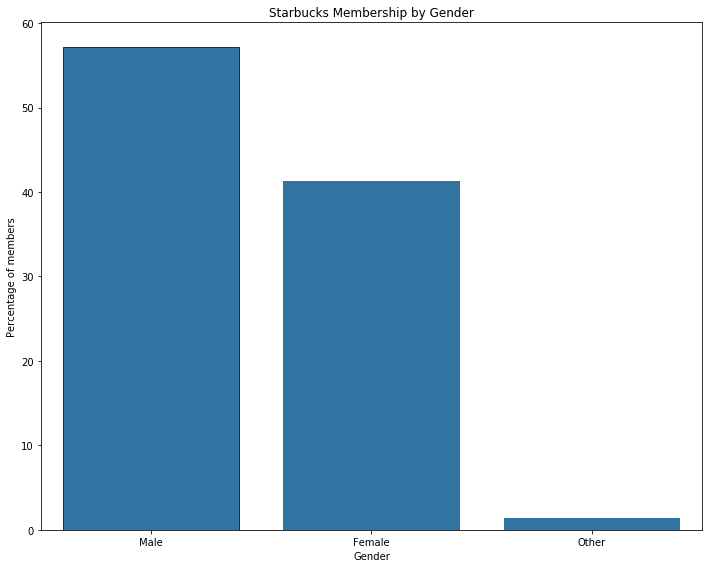

In [49]:

# # Get listing percentage for gender
# Analyzing the distribution of members according to gender.
genderclass_p = data2["gender"].value_counts(normalize=True) * 100
genderclass_count = data2["gender"].value_counts() 
print("\n\n\n\nlisting each gender Percentages :", genderclass_p, "\n\n\n\nlisting each gender Raw counts" , 
      genderclass_count, sep="\n" )



# Plot the gender class distribution
plt.figure(figsize=[10,8])
sns.barplot(x= genderclass_p.index, y = genderclass_p.values, color = bcolor, edgecolor="#2b2b28")
# plt.bar( ddf['index'], ddf.gender,  edgecolor="#2b2b28")
plt.xlabel("Gender")
plt.xticks([0,1,2],['Male','Female', 'Other'])
plt.ylabel("Percentage of members")
plt.title("Starbucks Membership by Gender")
plt.tight_layout()
plt.show()
    
    





listing each event Percentages :
transaction        45.445113
offer received     24.380596
offer viewed       18.279672
offer completed    11.894619
Name: event, dtype: float64




listing each event Raw counts
transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64


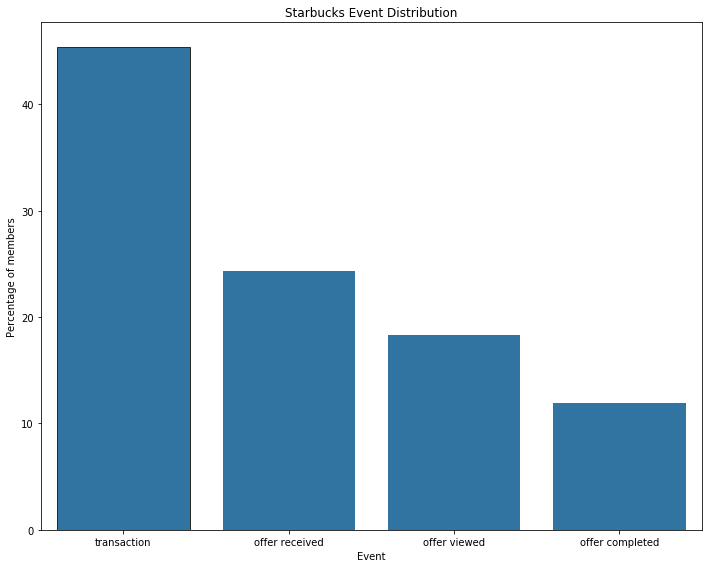

In [50]:
# # Get listing percentage of events
# Analyzing the distribution of events.
event_p = data["event"].value_counts(normalize=True) * 100
event_counts = data["event"].value_counts() 
print("\n\n\n\nlisting each event Percentages :", event_p, "\n\n\n\nlisting each event Raw counts" , event_counts, sep="\n" )


  
# Plot the event distribution
plt.figure(figsize=[10,8])
sns.barplot(x = event_p.index, y= event_p.values,  color = bcolor,   edgecolor="#2b2b28")
plt.xlabel("Event")
plt.ylabel("Percentage of members")
plt.title("Starbucks Event Distribution")
plt.tight_layout()
plt.show()
    


In [51]:
# get data for offer events
devent = data[data['event']!="transaction"].reset_index(drop=True)


# sorted bar chart on ordinal categories
# this method requires pandas v0.21 or later
ordering_ = ['offer received', 'offer viewed', 'offer completed']
t = pd.CategoricalDtype(categories= ordering_, ordered=True)

devent["event"] = devent["event"].astype(t)
devent.event.value_counts()

offer received     66501
offer viewed       49860
offer completed    32444
Name: event, dtype: int64





Offer events Percentages :
offer received     44.690031
offer viewed       33.506939
offer completed    21.803031
Name: event, dtype: float64




Offer events Raw counts
offer received     66501
offer viewed       49860
offer completed    32444
Name: event, dtype: int64


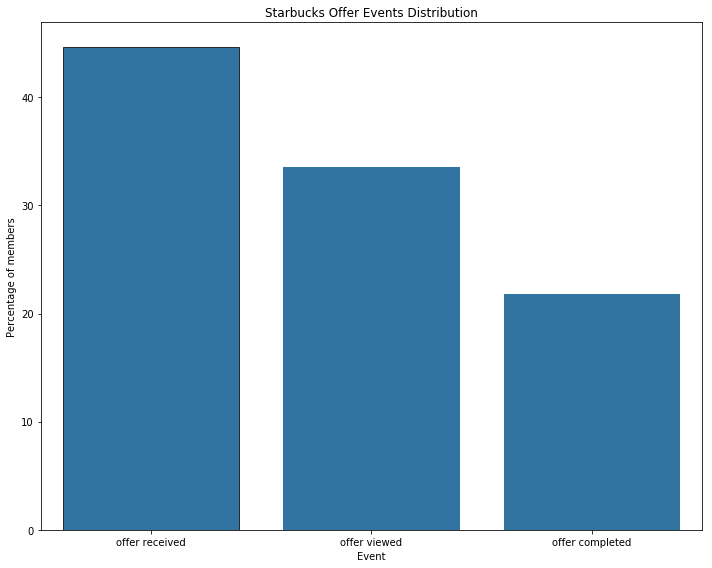

In [52]:
# # Get listing percentage of offer events
# Analyzing the distribution of offer events.
offerevents_p = devent["event"].value_counts(normalize=True) * 100
offerevents_count = devent["event"].value_counts() 
print("\n\n\n\nOffer events Percentages :", offerevents_p, "\n\n\n\nOffer events Raw counts" , 
      offerevents_count, sep="\n" )



  
# Plot the distribution of offer events
plt.figure(figsize=[10,8])
sns.barplot(x = offerevents_p.index, y= offerevents_p.values,  color = bcolor,   edgecolor="#2b2b28")
plt.xlabel("Event")
plt.ylabel("Percentage of members")
plt.title("Starbucks Offer Events Distribution")
plt.tight_layout()
plt.show()





offer events across gender Percentages :
gender                  F          M         O
event                                         
offer received  41.414668  57.003823  1.581509
transaction     41.296439  57.369640  1.333921
All             41.342327  57.227656  1.430017
 



offer events across gender Raw counts
gender             F     M    O    All
event                                 
offer received  2383  3280   91   5754
transaction     3746  5204  121   9071
All             6129  8484  212  14825
 



room_types per bourough Raw counts
gender                  F          M         O
event                                         
offer received  16.074199  22.124789  0.613828
transaction     25.268128  35.102867  0.816189


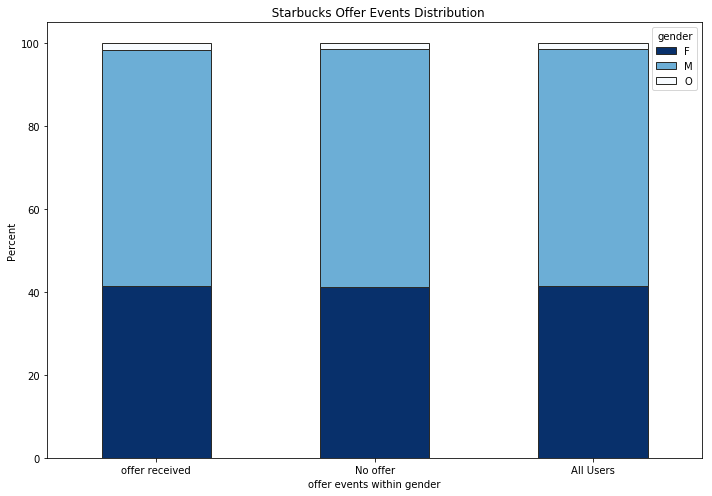

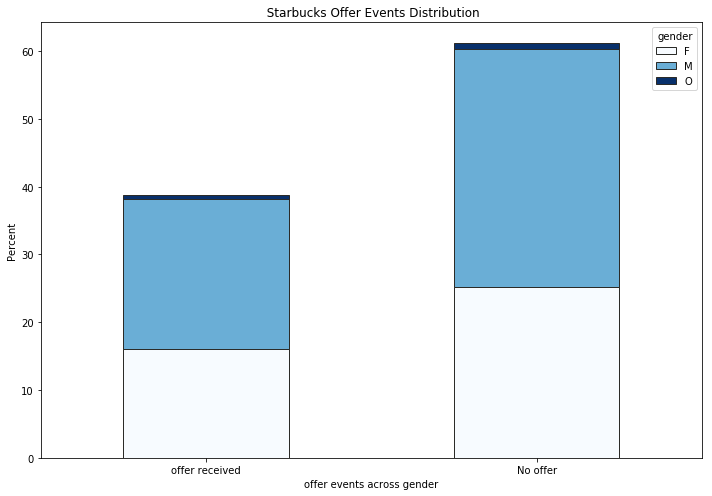

In [53]:

# # get the counts of offer events across  and within gender
hh = pd.crosstab(data2["event"], data2["gender"], normalize="index", margins = True).fillna(0) * 100
hh2 = pd.crosstab(data2["event"], data2["gender"],  margins = True).fillna(0)
hht = pd.crosstab(data2["event"], data2["gender"], normalize="all").fillna(0) * 100
print("\n\n\n\noffer events across gender Percentages :", hh, " \n\n\n\noffer events across gender Raw counts" , hh2,
        " \n\n\n\nroom_types per bourough Raw counts", hht , sep="\n")


# # Plot the distribution of offer within gender
hh.plot.bar(stacked=True, cmap='Blues_r', figsize=(10,7), edgecolor=["#2b2b28", "#2b2b28", "#2b2b28"])
plt.xticks(rotation=0)
plt.xlabel("offer events within gender")
plt.ylabel("Percent")
plt.xticks([0,1,2],['offer received','No offer', 'All Users'])
plt.title("  Starbucks Offer Events Distribution")
plt.tight_layout()
plt.show()


# RdBu_r, PuBu_r
# # Plot the distribution of offer across gender
hht.plot.bar(stacked=True, cmap='Blues', figsize=(10,7), edgecolor=["#2b2b28", "#2b2b28", "#2b2b28"])
plt.xticks(rotation=0)
plt.xlabel("offer events across gender")
plt.ylabel("Percent")
plt.xticks([0,1],['offer received','No offer'])
plt.title("  Starbucks Offer Events Distribution ")
plt.tight_layout()
plt.show()

In [54]:
data2.head()


,person,user_id,event,offer_id2,time,offer_id_rewards,offer_id,reward_amt,gender,age,...,reward,difficulty,duration,offer_type,offer_id_short,offerType2,Channel_email,Channel_mobile,Channel_social,Channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,1,offer received,1,0,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,F,75,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
3,e2127556f4f64592b11af22de27a7932,2,offer received,1,408,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,M,68,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
8,389bc3fa690240e798340f5a15918d5c,3,offer received,1,168,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,M,65,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
13,d058f73bf8674a26a95227db098147b1,4,offer received,1,504,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,F,56,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0
19,ebe7ef46ea6f4963a7dd49f501b26779,5,offer received,1,0,99999,9b98b8c7a33c4b65b9aebfe6a799e6d9,9999.0,M,59,...,5.0,5.0,7.0,bogo,e6d9,bogo-e6d9,1.0,1.0,0.0,1.0


In [55]:
data2.describe()

,user_id,offer_id2,time,offer_id_rewards,reward_amt,age,income,membershipDays,reward,difficulty,duration,Channel_email,Channel_mobile,Channel_social,Channel_web
count,14825.000000,14825.000000,14825.000000,14825.0,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.00000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,7413.000000,1.661180,202.347521,99999.0,3890.089490,54.393524,65404.991568,523.478988,62.506442,62.53855,2.696391,0.388128,0.386239,0.011130,0.379494
std,4279.753206,0.612378,185.469679,0.0,4865.661278,17.383705,21598.299410,419.205158,45.824601,45.78900,3.401795,0.487340,0.486903,0.104913,0.485277
min,1.000000,1.000000,0.000000,99999.0,0.050000,18.000000,30000.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3707.000000,1.000000,36.000000,99999.0,9.220000,42.000000,49000.000000,209.000000,5.000000,5.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7413.000000,2.000000,168.000000,99999.0,23.380000,55.000000,64000.000000,359.000000,99.000000,99.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11119.000000,2.000000,336.000000,99999.0,9999.000000,66.000000,80000.000000,798.000000,99.000000,99.00000,7.000000,1.000000,1.000000,0.000000,1.000000
max,14825.000000,10.000000,714.000000,99999.0,9999.000000,101.000000,120000.000000,1824.000000,99.000000,99.00000,10.000000,1.000000,1.000000,1.000000,1.000000


In [56]:
data2.shape

(14825, 25)

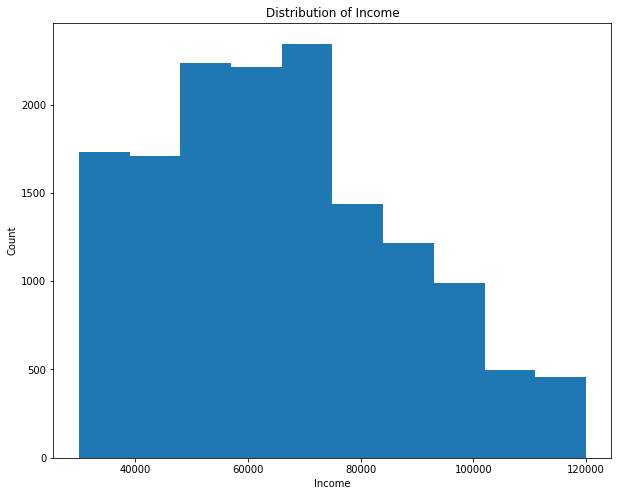

In [57]:
# Create a histogram of income
plt.figure(figsize=[10,8])
plt.hist(data2['income'], bins=10)
plt.title('Distribution of Income')
plt.ylabel("Count")
plt.xlabel('Income');

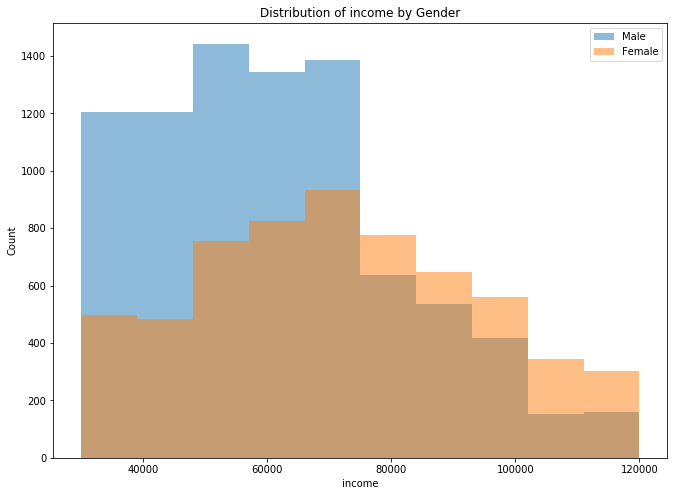

In [58]:
# Create a histogram of income among genders or only Males and females
plt.figure(figsize=[11,8])
plt.hist('income', data=data2[data2['gender'] == 'M'], alpha=0.5, label='Male', bins=10)
plt.hist('income', data=data2[data2['gender'] == 'F'], alpha=0.5, label='Female', bins=10)
plt.title('Distribution of income by Gender')
plt.xlabel('income')
plt.ylabel("Count")
plt.legend();

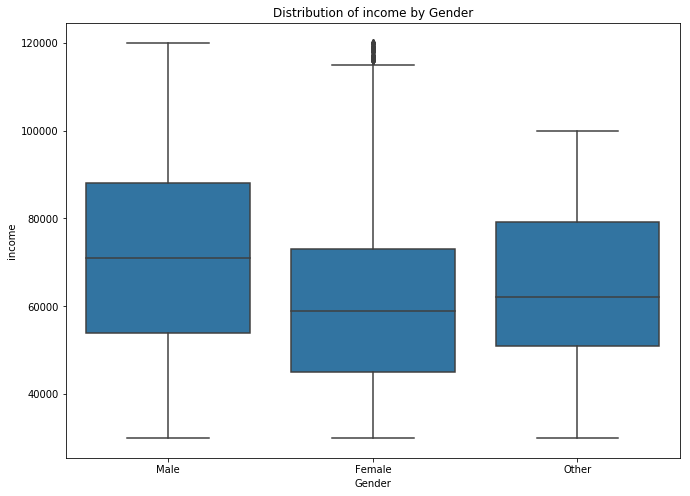

In [59]:
# Create a boxplot of income among genders 
plt.figure(figsize=[11,8])
sns.boxplot(x="gender", y="income", data=data2, color = bcolor)
plt.title('Distribution of income by Gender')
plt.xticks([0,1,2],['Male','Female', 'Other'])
plt.ylabel('income')
plt.xlabel("Gender")
plt.legend();

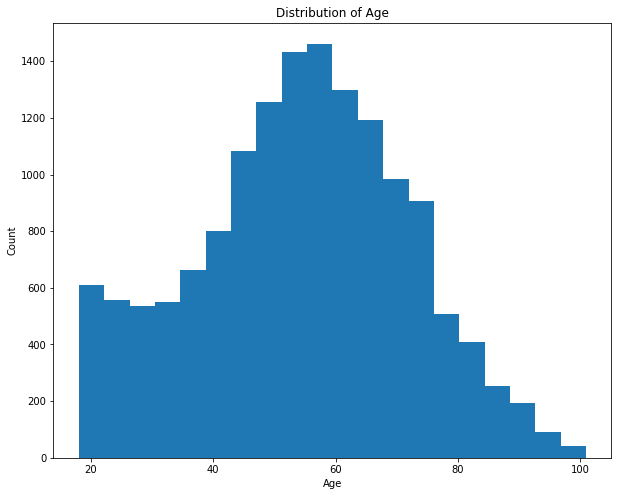

In [60]:
# Create a histogram of ages
plt.figure(figsize=[10,8])
plt.hist(data2['age'], bins=20)
plt.title('Distribution of Age')
plt.ylabel("Count")
plt.xlabel('Age');

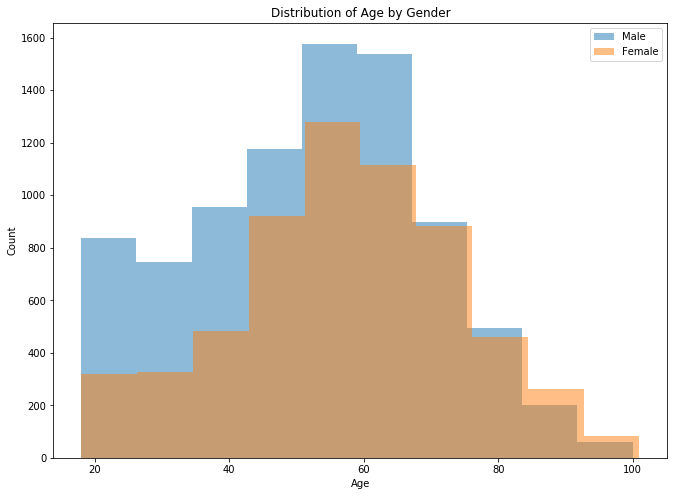

In [61]:
# Create a histogram of ages among genders for only Males and females
plt.figure(figsize=[11,8])
plt.hist('age', data=data2[data2['gender'] == 'M'], alpha=0.5, label='Male', bins=10)
plt.hist('age', data=data2[data2['gender'] == 'F'], alpha=0.5, label='Female', bins=10)
plt.title('Distribution of Age by Gender')
plt.xlabel('Age')
plt.ylabel("Count")
plt.legend();

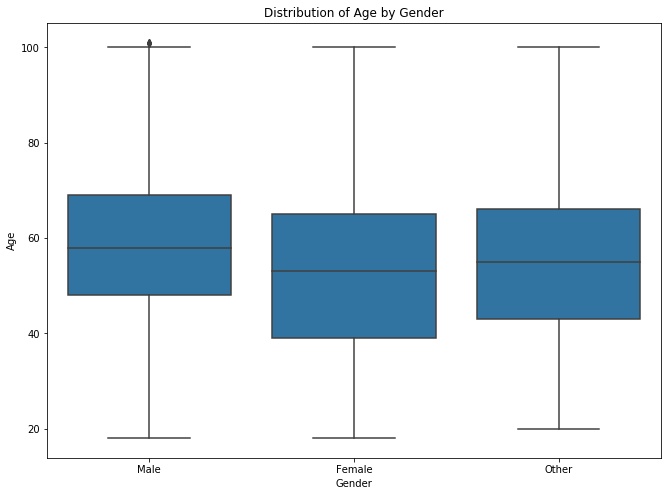

In [62]:
# Create a boxplot of ages among genders 
plt.figure(figsize=[11,8])
sns.boxplot(x="gender", y="age", data=data2, color = bcolor)
plt.title('Distribution of Age by Gender')
plt.xticks([0,1,2],['Male','Female', 'Other'])
plt.ylabel('Age')
plt.xlabel("Gender")
plt.legend();

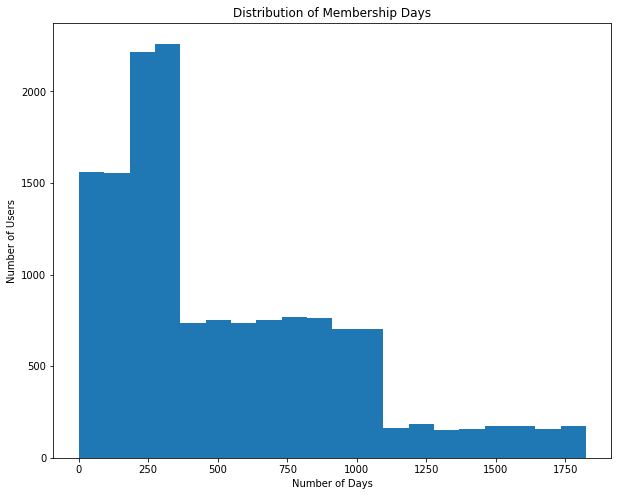

In [63]:
# Create a histogram of membership Days
plt.figure(figsize=[10,8])
plt.hist(data2['membershipDays'], bins=20)
plt.title('Distribution of Membership Days')
plt.ylabel("Number of Users")
plt.xlabel('Number of Days');

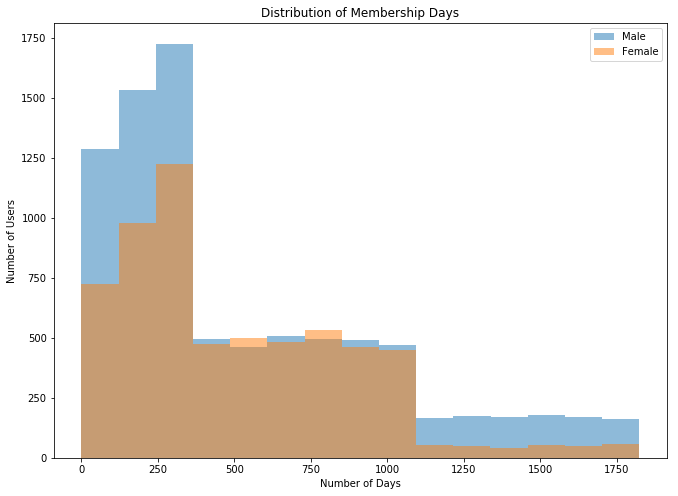

In [64]:
# Create a histogram of membership Days among genders or only Males and females
plt.figure(figsize=[11,8])
plt.hist('membershipDays', data=data2[data2['gender'] == 'M'], alpha=0.5, label='Male', bins=15)
plt.hist('membershipDays', data=data2[data2['gender'] == 'F'], alpha=0.5, label='Female', bins=15)
plt.title('Distribution of Membership Days')
plt.ylabel("Number of Users")
plt.xlabel('Number of Days')
plt.legend();

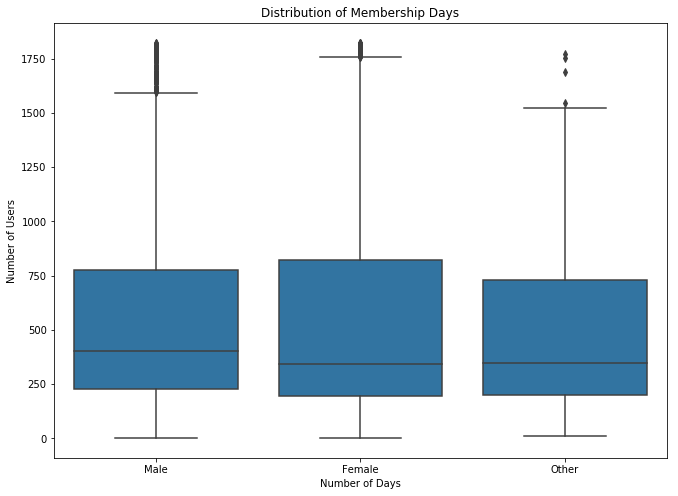

In [65]:
# Create a boxplot of membership Days among genders 
plt.figure(figsize=[11,8])
sns.boxplot(x="gender", y="membershipDays", data=data2, color = bcolor)
plt.title('Distribution of Membership Days')
plt.xticks([0,1,2],['Male','Female', 'Other'])
plt.title('Distribution of Membership Days')
plt.ylabel("Number of Users")
plt.xlabel('Number of Days')
plt.legend();

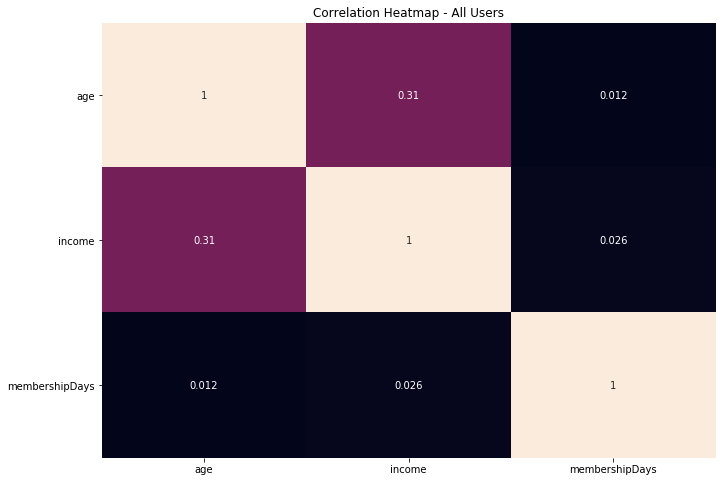

In [66]:
plt.figure(figsize=[11,8])
sns.heatmap(data2[["age", "income", "membershipDays"]].corr(), annot=True, cbar=False)
plt.title('Correlation Heatmap - All Users')
plt.yticks(rotation=0);

In [67]:
men = data2[data2['gender'] == 'M']
ladies = data2[data2['gender'] == 'F']

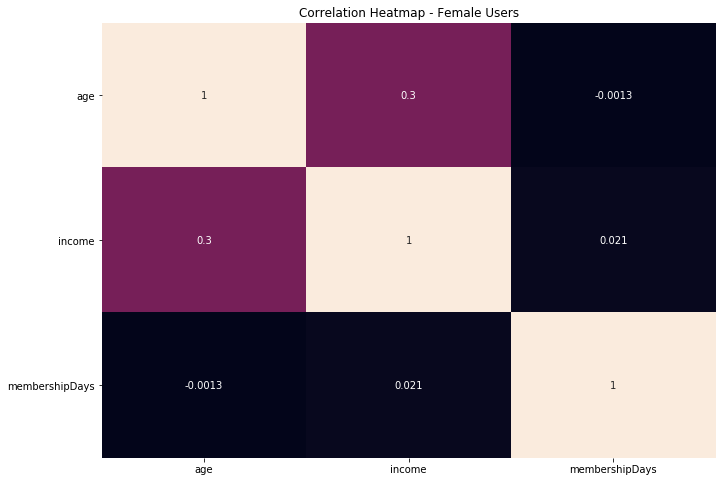

In [68]:
plt.figure(figsize=[11,8])
sns.heatmap(ladies[["age", "income", "membershipDays"]].corr(), annot=True, cbar=False)
plt.title('Correlation Heatmap - Female Users')
plt.yticks(rotation=0);

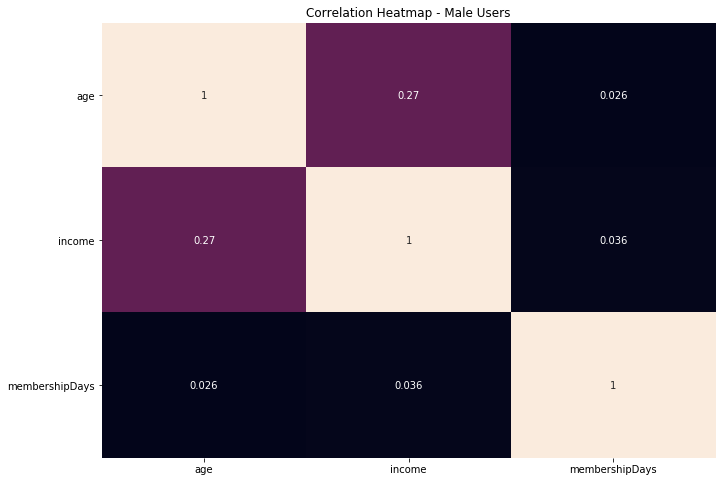

In [69]:
plt.figure(figsize=[11,8])
sns.heatmap(men[["age", "income", "membershipDays"]].corr(), annot=True, cbar=False)
plt.title('Correlation Heatmap - Male Users')
plt.yticks(rotation=0);

# D. Predictive modeling and answers to research question

## 1. Tackle reseach questions


 
# Question I
## Who is the typical Starbucks rewards mobile app user?
- Analysis of descriptive statistics of all variables in the dataset.



In [70]:
# create dataframe with one record per user
single_users = data.drop_duplicates(subset=['person'], keep="last")
single_users.person.nunique(), single_users.shape

(14825, (14825, 25))

## Analyze gender

In [71]:
# find the highest count gender
# the gender with most users is typical
single_users.gender.value_counts(normalize=True) * 100

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

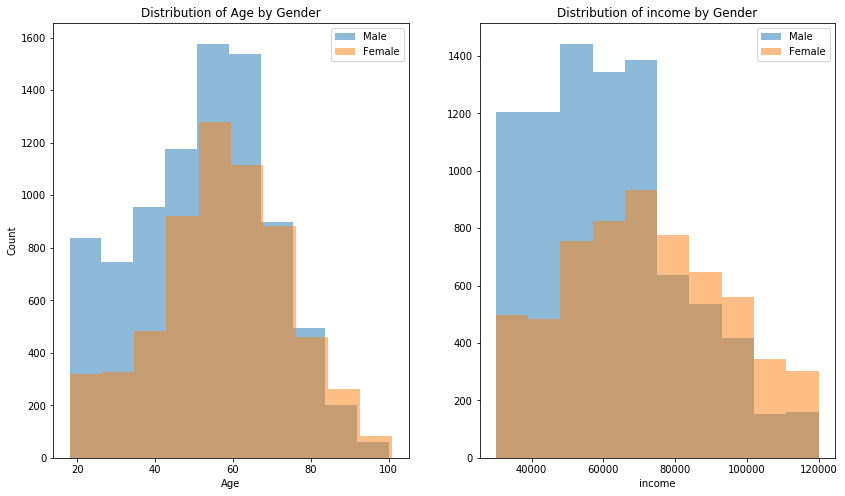

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8), sharey=True)
plt.subplot(121)

plt.hist('age', data=data2[data2['gender'] == 'M'], alpha=0.5, label='Male', bins=10)
plt.hist('age', data=data2[data2['gender'] == 'F'], alpha=0.5, label='Female', bins=10)
plt.title('Distribution of Age by Gender')
plt.xlabel('Age')
plt.ylabel("Count")
plt.legend();

plt.subplot(122)
# Create a histogram of income among genders or only Males and females
plt.hist('income', data=data2[data2['gender'] == 'M'], alpha=0.5, label='Male', bins=10)
plt.hist('income', data=data2[data2['gender'] == 'F'], alpha=0.5, label='Female', bins=10)
plt.title('Distribution of income by Gender')
plt.xlabel('income')
# plt.ylabel("Count")
plt.legend();

## Analyze age

In [73]:
# visual Normality check
def plot_dnorm(arr):
    plt.figure(figsize=[10,8])
    mean = np.mean(arr)
    variance = np.var(arr)
    sigma = np.sqrt(variance)
    
    x = np.linspace(min(arr), max(arr), len(arr))
    plt.hist(arr, normed=True)
    plt.xlim((min(arr)-mean/10, max(arr)+mean/10))


    plt.plot(x, mlab.normpdf(x, mean, sigma))


    plt.show()

In [74]:
# Distribution of users age is fairly normal, although the mean and median relatively close
single_users.age.describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [75]:
single_users.agegroups.value_counts(normalize=True) * 100

babyboomer      43.844857
genX            23.183811
elderlyadult    17.753794
millennials     15.217538
Name: agegroups, dtype: float64

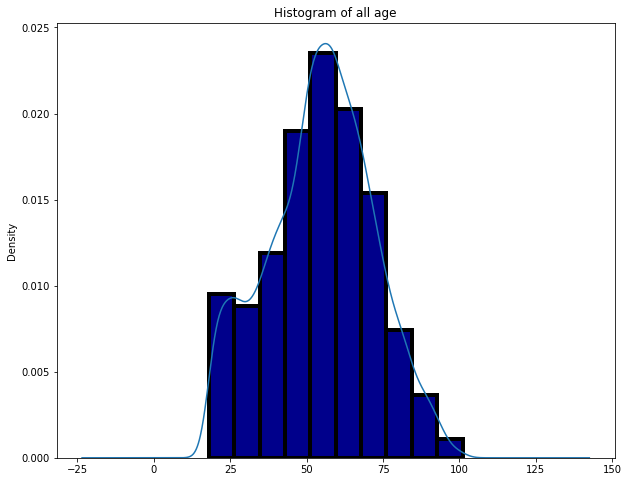

In [76]:
# Density Plot and Histogram of all age
plt.figure(figsize=[10,8])
single_users['age'].plot.hist(density=True, color = 'darkblue',
             edgecolor='black',linewidth = 4)
single_users['age'].plot.kde(legend=False, title="Histogram of all age");

In [77]:
data_age = single_users.query('age >= age.mean()-2 and age <= age.median()+2')
data_age.agegroups.value_counts()

babyboomer      1776
elderlyadult       0
genX               0
millennials        0
Name: agegroups, dtype: int64

## Analyze income

In [78]:
# Distribution of users income is poorly normal, although the mean and median relatively close
single_users.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [79]:
bb = single_users.incomegroups.value_counts(normalize=True) * 100
bb

Middle-income    84.222597
Lower-middle     15.183811
Lowest            0.593592
Higher-income     0.000000
Upper-middle      0.000000
Name: incomegroups, dtype: float64

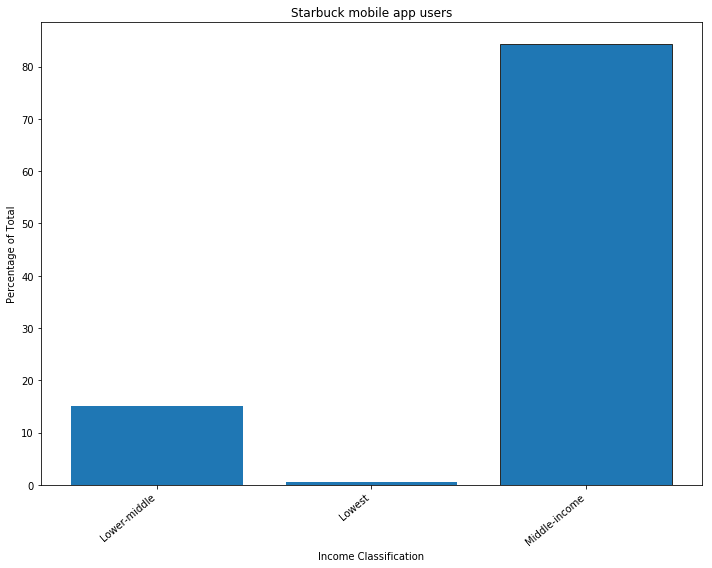

In [80]:
# # # plot the room types
plt.figure(figsize=[10,8])
plt.bar(bb.index[0:3], bb.values[0:3], edgecolor="#2b2b28")
plt.xlabel("Income Classification")
plt.xticks(rotation=40, ha='right')
plt.ylabel("Percentage of Total")
plt.title("Starbuck mobile app users")
plt.tight_layout()
plt.show()

In [81]:
bba = single_users.agegroups.value_counts(normalize=True) * 100
# bba =  bba.reset_index()
bba

babyboomer      43.844857
genX            23.183811
elderlyadult    17.753794
millennials     15.217538
Name: agegroups, dtype: float64

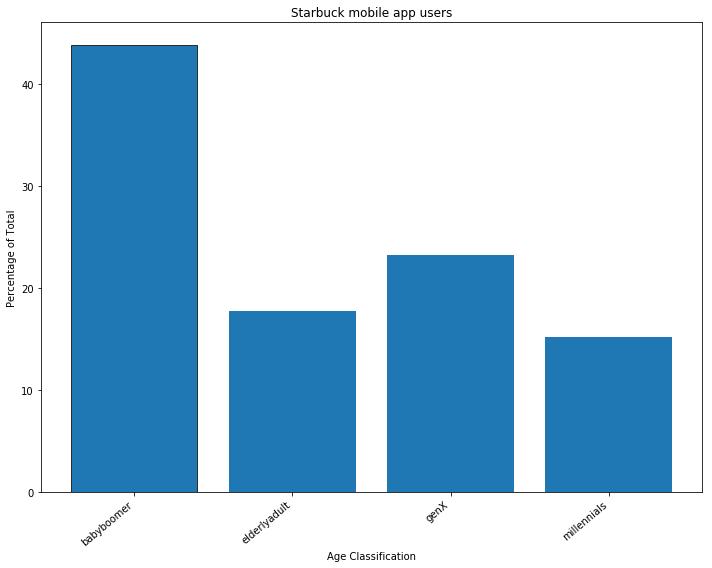

In [82]:
# # # plot the room types
plt.figure(figsize=[10,8])
plt.bar(bba.index, bba.values, edgecolor="#2b2b28")
plt.xlabel("Age Classification")
plt.xticks(rotation=40, ha='right')
plt.ylabel("Percentage of Total")
plt.title("Starbuck mobile app users")
plt.tight_layout()
plt.show()

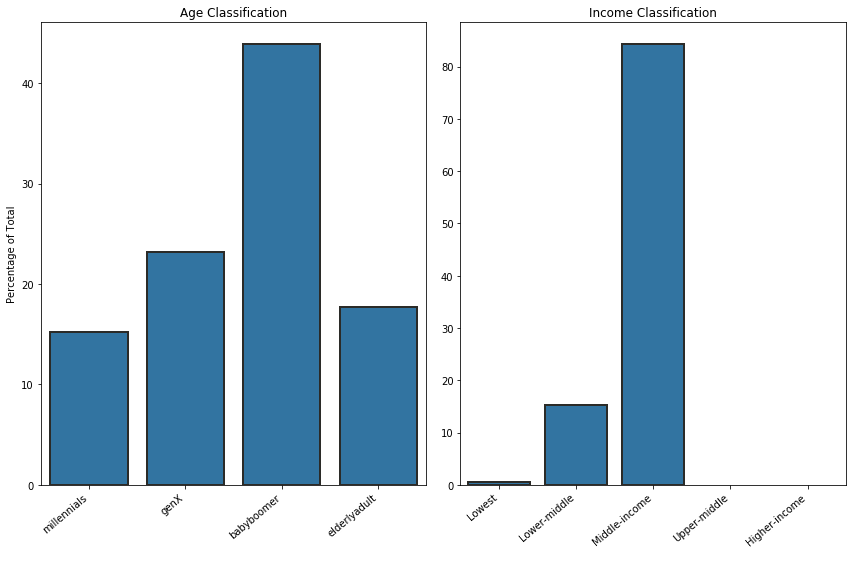

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8), sharey=True)
plt.subplot(121)
sns.barplot(x = bba.index, y= bba.values,  color = bcolor,   edgecolor=["#2b2b28","#2b2b28","#2b2b28","#2b2b28"] , linewidth = 2)
plt.xlabel(" ")
plt.xticks(rotation=40, ha='right')
plt.ylabel("Percentage of Total")
plt.title("Age Classification")
plt.tight_layout()
bbc = bb[:3]
plt.subplot(122)

sns.barplot(x = bbc.index, y= bbc.values,  color = bcolor,   edgecolor=["#2b2b28","#2b2b28","#2b2b28","#2b2b28"] , linewidth = 2)
plt.xlabel(" ")
plt.xticks(rotation=40, ha='right')
plt.title("Income Classification")
plt.tight_layout()
plt.show()

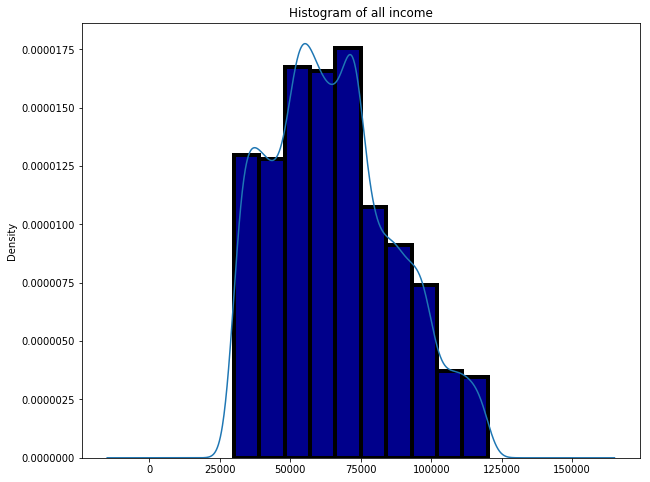

In [84]:
# Density Plot and Histogram of all income
plt.figure(figsize=[10,8])
single_users['income'].plot.hist(density=True, color = 'darkblue',
             edgecolor='black',linewidth = 4)
single_users['income'].plot.kde(legend=False, title="Histogram of all income");


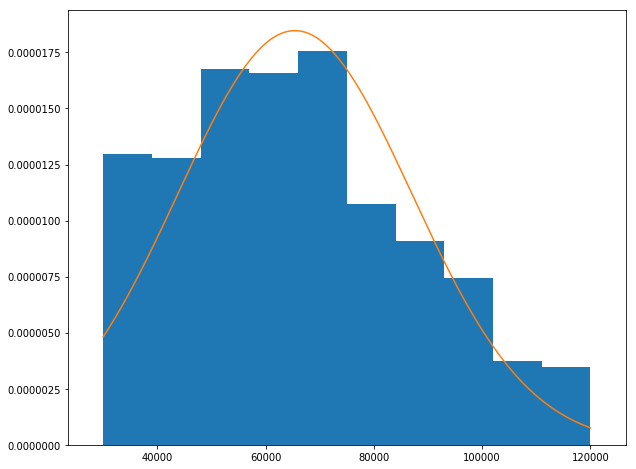

In [85]:
plot_dnorm(single_users["income"])

In [86]:
data_income = single_users.query('income >= income.median()-2 and income <= income.mean()+2')
data_income.incomegroups.value_counts()

Middle-income    496
Higher-income      0
Upper-middle       0
Lower-middle       0
Lowest             0
Name: incomegroups, dtype: int64

 # Question II
 ## Which demographic group respond best to which offer type?
  - Analyzing the response rate of each gender and age groups.

In [87]:
oevent = ['offer received', 'offer viewed', 'offer completed']
ooffer = ['informational', 'discount', 'bogo']
toevent = pd.api.types.CategoricalDtype(categories= oevent, ordered=True)
tooffer = pd.api.types.CategoricalDtype(categories= ooffer, ordered=True)



# keep only users that received an offer
dada = data[data['event'] != "transaction"]
data8 = dada.drop_duplicates(subset=['person'], keep="last")
data8['eventFinal'] = data8['event'].astype(toevent).apply(lambda x: "No response" if x =="offer received" else x)
data8['offer_type'] = data8['offer_type'].astype(tooffer)



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [88]:
# check total number of users and those with complete dataset the received an offer
clean_data.person.nunique(), data8.shape

(17000, (14820, 26))

In [89]:
offf2 = data8.eventFinal.value_counts(normalize=True)*100
offf2

offer completed    53.245614
offer viewed       38.063428
No response         8.690958
Name: eventFinal, dtype: float64

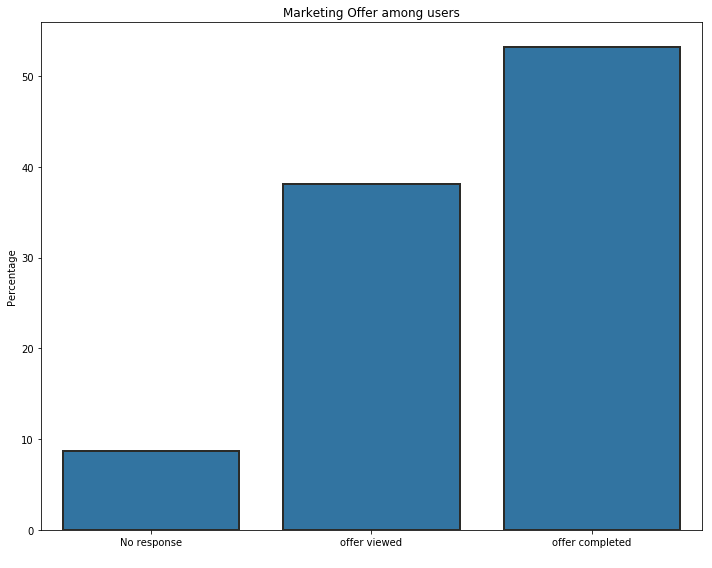

In [90]:
plt.figure(figsize=[10,8])
sns.barplot(x = offf2.index, y= offf2.values,  color = bcolor,   edgecolor=["#2b2b28","#2b2b28","#2b2b28","#2b2b28"] , linewidth = 2)
plt.xlabel(" ")
plt.title("Marketing Offer among users")
plt.ylabel("Percentage")
plt.tight_layout()
plt.show()

In [91]:
data8.offer_type.value_counts()

discount         9881
bogo             4040
informational     899
Name: offer_type, dtype: int64

In [92]:
offf = data8.offer_type.value_counts(normalize=True)*100
# offf = offf.reset_index()
offf

discount         66.673414
bogo             27.260459
informational     6.066127
Name: offer_type, dtype: float64

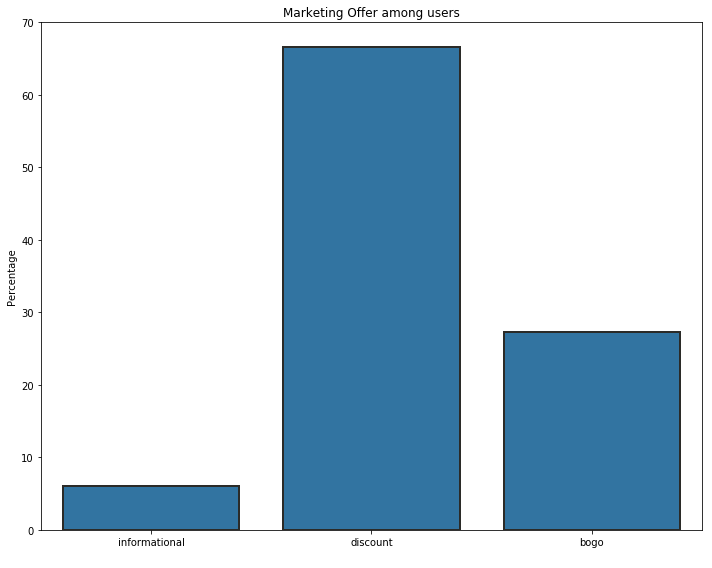

In [93]:
plt.figure(figsize=[10,8])
sns.barplot(x = offf.index, y= offf.values,  color = bcolor,   edgecolor=["#2b2b28","#2b2b28","#2b2b28","#2b2b28"] , linewidth = 2)
plt.xlabel(" ")
plt.title("Marketing Offer among users")
plt.ylabel("Percentage")
plt.tight_layout()
plt.show()

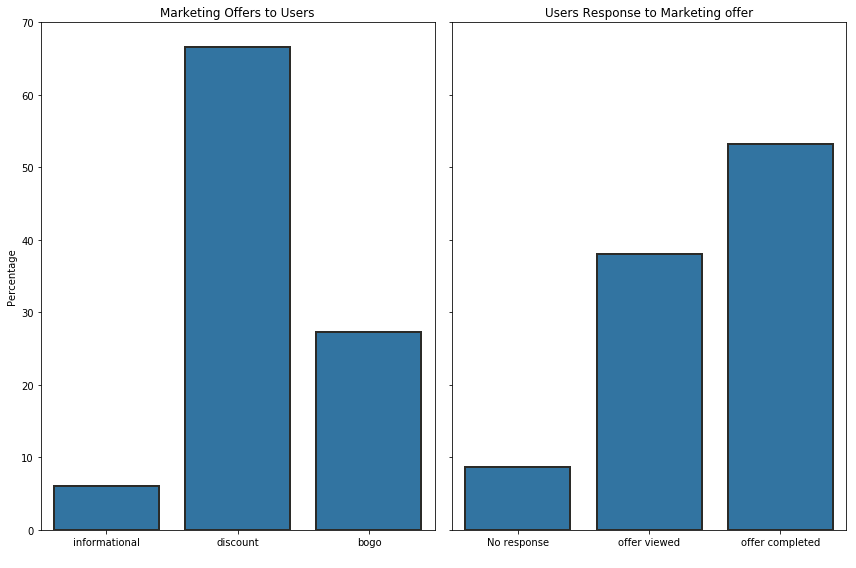

In [94]:
# Plot the distribution
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,8), sharey=True)

sns.barplot(x = offf.index, y= offf.values,  color = bcolor,   edgecolor=["#2b2b28","#2b2b28","#2b2b28","#2b2b28"] , linewidth = 2, ax=ax1)
plt.xlabel(" ")
ax1.set_title("Marketing Offers to Users")
ax1.set_ylabel("Percentage")
plt.tight_layout()

sns.barplot(x = offf2.index, y= offf2.values,  color = bcolor,   edgecolor=["#2b2b28","#2b2b28","#2b2b28","#2b2b28"] , linewidth = 2, ax=ax2)
plt.xlabel(" ")
plt.title("Users Response to Marketing offer")
# plt.ylabel("Percentage")
plt.tight_layout()
plt.show()




In [95]:
offerevents2 = pd.crosstab(data8["offer_type"], data8["eventFinal"], normalize="index",  margins = True).fillna(0)*100
offerevents2 = offerevents2.reset_index()
offerevents2

eventFinal,offer_type,No response,offer viewed,offer completed
0,informational,43.381535,56.618465,0.000000
1,discount,7.883817,30.037446,62.078737
2,bogo,2.945545,53.564356,43.490099
3,All,8.690958,38.063428,53.245614


In [96]:
offerevents = pd.crosstab(data8["offer_type"], data8["eventFinal"], normalize="columns",  margins = True).fillna(0)*100
offerevents = offerevents.reset_index()
offerevents

eventFinal,offer_type,No response,offer viewed,offer completed,All
0,informational,30.279503,9.023223,0.000000,6.066127
1,discount,60.481366,52.614785,77.734127,66.673414
2,bogo,9.239130,38.361993,22.265873,27.260459


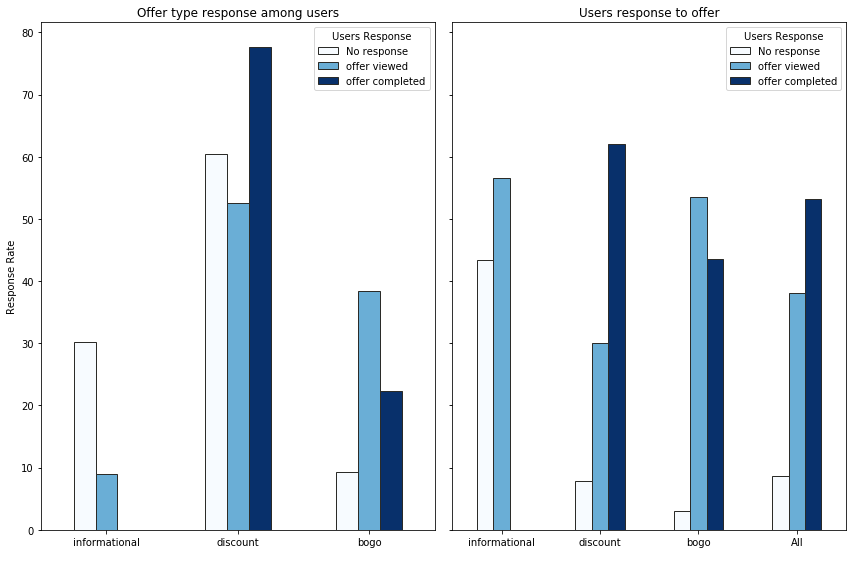

In [97]:
# Plot the distribution
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,8), sharey=True)
offerevents.plot(x='offer_type' , y=offerevents.columns.tolist()[1:4],  kind="bar", cmap="Blues", edgecolor=["#2b2b28", "#2b2b28", "#2b2b28", 
                                                                                           "#2b2b28", "#2b2b28", "#2b2b28", 
                                                                                           "#2b2b28", "#2b2b28"], ax=ax1)

ax1.set_xlabel(" ")
ax1.set_ylabel("Response Rate")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_title("Offer type response among users")
ax1.legend(title="Users Response")


offerevents2.plot(x='offer_type' , y=offerevents2.columns.tolist()[1:4],  kind="bar", cmap="Blues", edgecolor=["#2b2b28", "#2b2b28", "#2b2b28", 
                                                                                           "#2b2b28", "#2b2b28", "#2b2b28", 
                                                                                           "#2b2b28", "#2b2b28"], ax=ax2)

plt.xlabel(" ")
plt.ylabel("Response Rate")
plt.xticks(rotation=0)
plt.title("Users response to offer")
plt.legend(title="Users Response")
plt.tight_layout()
plt.show()

In [98]:
hh22 = pd.crosstab(data8["event"], data8["eventFinal"],  margins = True).fillna(0)
hh22

eventFinal,No response,offer viewed,offer completed,All
event,,,,
offer completed,0,0,7891,7891
offer received,1288,0,0,1288
offer viewed,0,5641,0,5641
All,1288,5641,7891,14820


In [99]:
data8.eventFinal.value_counts()

offer completed    7891
offer viewed       5641
No response        1288
Name: eventFinal, dtype: int64

In [100]:
data8.groupby(['event']).groups.keys()

dict_keys(['offer completed', 'offer received', 'offer viewed'])

In [101]:
data8['event'].value_counts()

offer completed    7891
offer viewed       5641
offer received     1288
Name: event, dtype: int64

In [102]:
pd.crosstab(data8["offer_type"], data8["gender"],  margins = True).fillna(0)

gender,F,M,O,All
offer_type,,,,
informational,384,502,13,899
discount,4083,5647,151,9881
bogo,1658,2334,48,4040
All,6125,8483,212,14820


In [103]:
pd.crosstab(data8["eventFinal"], data8["gender"], normalize="columns", margins = True).fillna(0) * 100

gender,F,M,O,All
eventFinal,,,,
No response,7.314286,9.772486,5.188679,8.690958
offer viewed,33.093878,41.754096,33.962264,38.063428
offer completed,59.591837,48.473417,60.849057,53.245614


In [104]:
pd.crosstab(data8["eventFinal"], data8["gender"], normalize="index", margins = True).fillna(0) * 100

gender,F,M,O
eventFinal,,,
No response,34.782609,64.363354,0.854037
offer viewed,35.933345,62.790285,1.276369
offer completed,46.255227,52.109999,1.634774
All,41.329285,57.240216,1.430499


In [105]:
pd.crosstab(data8["offer_type"], data8["gender"], normalize="index", margins = True).fillna(0) * 100

gender,F,M,O
offer_type,,,
informational,42.714127,55.839822,1.446051
discount,41.321729,57.150086,1.528185
bogo,41.039604,57.772277,1.188119
All,41.329285,57.240216,1.430499


In [106]:
pd.crosstab(data8["offer_type"], data8["gender"], normalize="columns", margins = True).fillna(0) * 100

gender,F,M,O,All
offer_type,,,,
informational,6.269388,5.917718,6.132075,6.066127
discount,66.661224,66.568431,71.226415,66.673414
bogo,27.069388,27.513851,22.641509,27.260459


In [107]:
yy9 = pd.crosstab(data8["eventFinal"], data8["incomegroups"], normalize="columns", margins = True).fillna(0) * 100
yy9 = yy9.reset_index()

In [108]:
ordering_combine = ['informational-No response','informational-offer viewed', 
                    'discount-No response','discount-offer viewed','discount-offer completed',
                    'bogo-No response', 'bogo-offer viewed', 'bogo-offer completed']
t_combine = pd.CategoricalDtype(categories= ordering_combine, ordered=True)
data8['combine'] = data8[['offer_type','eventFinal']].agg('-'.join, axis=1).astype(t_combine)



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [109]:
data8['combine'].value_counts().index

CategoricalIndex(['discount-offer completed', 'discount-offer viewed',
                  'bogo-offer viewed', 'bogo-offer completed',
                  'discount-No response', 'informational-offer viewed',
                  'informational-No response', 'bogo-No response'],
                 categories=['informational-No response', 'informational-offer viewed', 'discount-No response', 'discount-offer viewed', 'discount-offer completed', 'bogo-No response', 'bogo-offer viewed', 'bogo-offer completed'], ordered=True, dtype='category')

## Response rate among Gender

In [110]:
bbb_p = pd.crosstab(data8["combine"], data8["gender"], normalize="index", margins = True).fillna(0) * 100
bbb_p = bbb_p.reset_index()
bbb_p

gender,combine,F,M,O
0,informational-No response,41.538462,57.435897,1.025641
1,informational-offer viewed,43.614931,54.616896,1.768173
2,discount-No response,30.937099,68.292683,0.770218
3,discount-offer viewed,37.297844,61.118598,1.583558
4,discount-offer completed,44.587545,53.814803,1.597652
5,bogo-No response,37.815126,61.344538,0.840336
6,bogo-offer viewed,32.255083,67.005545,0.739372
7,bogo-offer completed,52.077405,46.158224,1.764371
8,All,41.329285,57.240216,1.430499


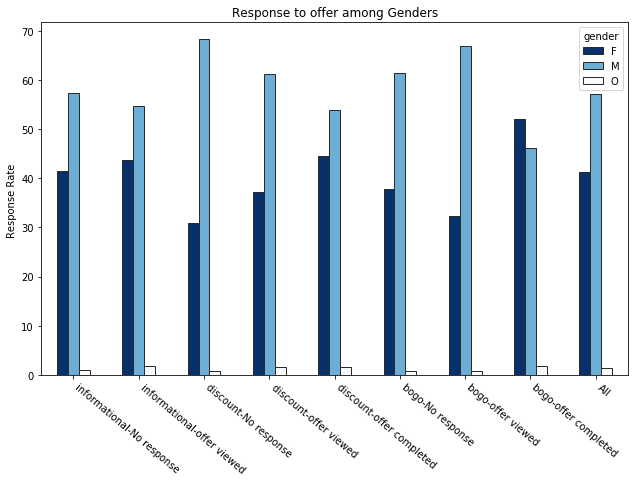

In [111]:
plt.figure(figsize=[14,8])
# Plot the distribution
bbb_p.plot(x='combine' , y=['F','M','O'],  kind="bar",figsize=(9,7), cmap="Blues_r", edgecolor=["#2b2b28", "#2b2b28", "#2b2b28", 
                                                                                           "#2b2b28", "#2b2b28", "#2b2b28", 
                                                                                           "#2b2b28", "#2b2b28","#2b2b28", "#2b2b28"])
plt.xlabel(" ")
plt.ylabel("Response Rate ")
plt.xticks(rotation=-40,ha="left")
plt.title("Response to offer among Genders")
# plt.legend(['Female', 'Male','Undisclosed'])
plt.tight_layout()
plt.show()


In [112]:
bbb_p

gender,combine,F,M,O
0,informational-No response,41.538462,57.435897,1.025641
1,informational-offer viewed,43.614931,54.616896,1.768173
2,discount-No response,30.937099,68.292683,0.770218
3,discount-offer viewed,37.297844,61.118598,1.583558
4,discount-offer completed,44.587545,53.814803,1.597652
5,bogo-No response,37.815126,61.344538,0.840336
6,bogo-offer viewed,32.255083,67.005545,0.739372
7,bogo-offer completed,52.077405,46.158224,1.764371
8,All,41.329285,57.240216,1.430499


## Response rate among Age groups

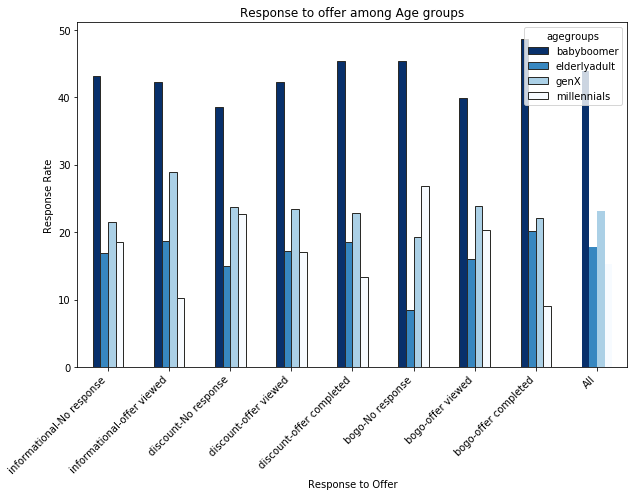

In [113]:
age_cp = pd.crosstab(data8["combine"], data8["agegroups"], normalize="index", margins = True).fillna(0) * 100
age_cp = age_cp.reset_index()

# Plot the distribution
age_cp.plot(x='combine' , y=['babyboomer', 'elderlyadult', 'genX', 'millennials'],  kind="bar",figsize=(9,7), cmap="Blues_r", 
                                                                                    edgecolor=["#2b2b28", "#2b2b28", "#2b2b28", 
                                                                                           "#2b2b28", "#2b2b28", "#2b2b28", 
                                                                                           "#2b2b28", "#2b2b28"])
plt.xlabel("Response to Offer")
plt.ylabel("Response Rate")
plt.xticks(rotation=45,ha="right")
plt.title("Response to offer among Age groups")
plt.tight_layout()
plt.show()

In [114]:
age_cp

agegroups,combine,millennials,genX,babyboomer,elderlyadult
0,informational-No response,18.461538,21.538462,43.076923,16.923077
1,informational-offer viewed,10.216110,28.880157,42.239686,18.664047
2,discount-No response,22.721438,23.748395,38.510911,15.019255
3,discount-offer viewed,17.082210,23.450135,42.318059,17.149596
4,discount-offer completed,13.302902,22.791001,45.435279,18.470818
5,bogo-No response,26.890756,19.327731,45.378151,8.403361
6,bogo-offer viewed,20.332717,23.798521,39.833641,16.035120
7,bogo-offer completed,9.106431,22.140011,48.662493,20.091064
8,All,15.222672,23.191633,43.839406,17.746289


## Response rate among Income groups

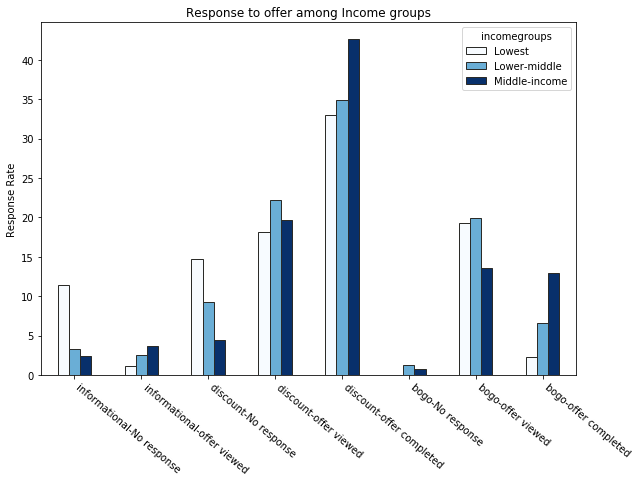

In [115]:
income_cp = pd.crosstab(data8["combine"], data8["incomegroups"], normalize="columns", margins = True).fillna(0) * 100
income_cp = income_cp.reset_index()
# Plot the distribution
income_cp.plot(x='combine' , y=['Lowest','Lower-middle', 'Middle-income'],  kind="bar",figsize=(9,7), cmap="Blues", 
                                                                                    edgecolor=["#2b2b28", "#2b2b28", "#2b2b28", 
                                                                                           "#2b2b28", "#2b2b28", "#2b2b28", 
                                                                                           "#2b2b28", "#2b2b28"])
plt.xlabel(" ")
plt.ylabel("Response Rate")
plt.xticks(rotation=-40,ha="left")
plt.title("Response to offer among Income groups")
plt.tight_layout()
plt.show()

In [116]:
income_cp

incomegroups,combine,Lowest,Lower-middle,Middle-income,All
0,informational-No response,11.363636,3.334815,2.443323,2.631579
1,informational-offer viewed,1.136364,2.578924,3.604903,3.434548
2,discount-No response,14.772727,9.204091,4.478090,5.256410
3,discount-offer viewed,18.181818,22.232103,19.642714,20.026991
4,discount-offer completed,32.954545,34.859938,42.625971,41.390013
5,bogo-No response,0.000000,1.289462,0.720981,0.802969
6,bogo-offer viewed,19.318182,19.964429,13.602499,14.601889
7,bogo-offer completed,2.272727,6.536238,12.881519,11.855601



# Question III
## Who will response to an offer?
- Build machine learning model that predicts whether or not someone will respond to an offer.





Offer events Percentages :
offer completed    53.245614
offer viewed       38.063428
No response         8.690958
Name: eventFinal, dtype: float64




Offer events Raw counts
offer completed    7891
offer viewed       5641
No response        1288
Name: eventFinal, dtype: int64


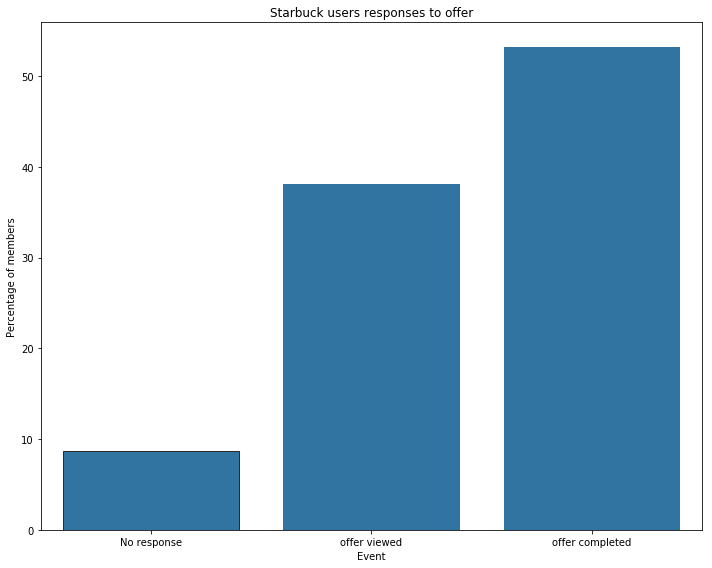

In [117]:
# # Get listing percentage of offer response
# Analyzing the distribution of offer response.
offerevents_p = data8["eventFinal"].value_counts(normalize=True) * 100
offerevents_count = data8["eventFinal"].value_counts() 
print("\n\n\n\nOffer events Percentages :", offerevents_p, "\n\n\n\nOffer events Raw counts" , 
      offerevents_count, sep="\n" )

  
# Plot the distribution of offer response
plt.figure(figsize=[10,8])
sns.barplot(x = offerevents_p.index, y= offerevents_p.values,  color = bcolor,   edgecolor="#2b2b28")
plt.xlabel("Event")
plt.ylabel("Percentage of members")
plt.title("Starbuck users responses to offer")
plt.tight_layout()
plt.show()

In [118]:
def pre_modelling(dataset):
    """
    
    
    
    """
    
    selected_columns = ['time', 'reward', 'gender', 'age', 'income',
       'membershipDays', 'difficulty', 'duration',
       'Channel_email', 'Channel_mobile', 'Channel_social', 'Channel_web',
       'eventFinal', 'offer_type']
    
    data = dataset.copy()
    data = data[selected_columns]
    tt = data.offer_type.values
    
    data = pd.get_dummies(data, columns=['gender', 'offer_type'], prefix_sep="_")

    data['offerType'] = tt
    
    y = data.pop('eventFinal')
    
    y = pd.get_dummies(y, prefix_sep="_")
    y["offer viewed"] = y.apply(lambda x: x[2] if x[2] == 1 else x[1], axis=1)
    
    X_train, X_test, Y_train, Y_test = train_test_split(
                        data.iloc[:,:-4], y, test_size=0.2, stratify=data.iloc[:,-1], random_state=0)

    
    return X_train, X_test, Y_train, Y_test

In [119]:
X_train, X_test, y_train, y_test = pre_modelling(data8)

In [120]:
X_train.head()

,time,reward,age,income,membershipDays,difficulty,duration,Channel_email,Channel_mobile,Channel_social,Channel_web,gender_F,gender_M,gender_O
227768,336,0.0,30,47000.0,238,0.0,4.0,1.0,1.0,0.0,1.0,0,1,0
291138,36,3.0,53,113000.0,185,7.0,7.0,1.0,1.0,1.0,1.0,1,0,0
302913,240,3.0,19,53000.0,211,7.0,7.0,1.0,1.0,1.0,1.0,0,1,0
270937,180,10.0,56,54000.0,79,10.0,5.0,1.0,1.0,1.0,1.0,0,1,0
300333,450,3.0,32,31000.0,82,7.0,7.0,1.0,1.0,1.0,1.0,1,0,0


In [121]:
y_test.head()

,No response,offer viewed,offer completed
257804,0,1,1
244614,0,1,1
275538,0,1,1
306386,0,1,1
249879,0,1,0


In [122]:
# search for best estimator
category_names = y_train.columns.tolist()
estimators = [
    ("RandomForestClassifier", MultiOutputClassifier(RandomForestClassifier(criterion = 'entropy', n_estimators=500, max_depth=20, random_state=0))),
    ("LinearSVC", MultiOutputClassifier(LinearSVC())),
    ("DecisionTreeClassifier", MultiOutputClassifier(DecisionTreeClassifier(max_depth = 20))),
    ("LogisticRegression", MultiOutputClassifier(LogisticRegression(random_state=0)))
]

for name, estimator in estimators:
    model = make_pipeline(MaxAbsScaler(), estimator)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(name," mean_absolute_error : ", mean_absolute_error(y_test, pred))
    print(name," mean_squared_error: ", mean_squared_error(y_test, pred))
    print(name," Root mean_squared_error: ", np.sqrt(mean_squared_error(y_test, pred)))
    print(name," R2_squared : ", r2_score(pred, y_test))
    print(name," Accuracy : ", model.score(X_test, y_test), end="\n\n")
    
    # Calculate accuracy
    accuracy = (pred == y_test).mean()
    accuracyscore = model.score(X_test, y_test)
    
    
    print(f"Model Accuracy:")
    print(f'{accuracy}\n\n')
    print(f"Model Accuracy score: {accuracyscore}\n\n")

RandomForestClassifier  mean_absolute_error :  0.13000449842555106
RandomForestClassifier  mean_squared_error:  0.13000449842555106
RandomForestClassifier  Root mean_squared_error:  0.36056136568627406
RandomForestClassifier  R2_squared :  0.04817299446217146
RandomForestClassifier  Accuracy :  0.684885290148448

Model Accuracy:
No response        0.943995
offer viewed       0.943995
offer completed    0.721997
dtype: float64


Model Accuracy score: 0.684885290148448


LinearSVC  mean_absolute_error :  0.16216824111560954
LinearSVC  mean_squared_error:  0.16216824111560954
LinearSVC  Root mean_squared_error:  0.4027011809215483
LinearSVC  R2_squared :  -4.3102358084330685
LinearSVC  Accuracy :  0.611336032388664

Model Accuracy:
No response        0.919703
offer viewed       0.919703
offer completed    0.674089
dtype: float64


Model Accuracy score: 0.611336032388664


DecisionTreeClassifier  mean_absolute_error :  0.14192532613585243
DecisionTreeClassifier  mean_squared_error:  0.1419

In [123]:
def build_model():
    """The build_model function build a model pipeline
    Args: None
    Returns:
        model(pipeline): model pipeline for fitting, prediction and scoring
    """
    # create pipeline
    plu = Pipeline([
                     ("mascaler", MaxAbsScaler()),
                     ('rforest', MultiOutputClassifier(RandomForestClassifier(criterion = 'entropy', n_estimators=500, max_depth=20, 
                                                                              oob_score = True, bootstrap = True, n_jobs=-1, random_state=0)))
            ])


    return plu




In [124]:

def evaluate_model(model, X_text, Y_test):
    """The evaluate_model function scores the performance of trained model
        on test (unseen) text and categories
    Args:
        model (model): model to evaluate
        X_text (numpy arrays): the test (unseen) tokenized text
        Y_test (numpy arrays): the test (unseen) target used for evaluation
        category_names(list): list containing the name of the categories
    Returns: None
            print out the accuracy and confusion metrics
    """
    sp = {"end": "\n\n", "sep": "\n\n"}

    # predict using the model
    pred = model.predict(X_text)

    # Calculate accuracy
    accuracy = (pred == Y_test).mean()
    accuracyscore = model.score(X_text, Y_test)    
    
    print(f"Model Accuracy:")
    print(f'{accuracy}\n\n')
    print(f"Model Accuracy score: {accuracyscore}\n\n")




In [125]:
treemodel = build_model()
treemodel.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('mascaler', MaxAbsScaler(copy=True)), ('rforest', MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,...-1,
            oob_score=True, random_state=0, verbose=0, warm_start=False),
           n_jobs=1))])

In [126]:
X_test.columns

Index(['time', 'reward', 'age', 'income', 'membershipDays', 'difficulty',
       'duration', 'Channel_email', 'Channel_mobile', 'Channel_social',
       'Channel_web', 'gender_F', 'gender_M', 'gender_O'],
      dtype='object')

In [127]:
evaluate_model(treemodel, X_test, y_test)

Model Accuracy:
No response        0.943995
offer viewed       0.943995
offer completed    0.721997
dtype: float64


Model Accuracy score: 0.684885290148448




In [128]:
treemodel

Pipeline(memory=None,
     steps=[('mascaler', MaxAbsScaler(copy=True)), ('rforest', MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,...-1,
            oob_score=True, random_state=0, verbose=0, warm_start=False),
           n_jobs=1))])

In [129]:
treemodel.named_steps['rforest'].estimator.criterion

'entropy'

In [130]:
# let get the feature importance
def dfform(lstt):
    """The dfform function form pandas dataframe from list
 
    Args: 
        lstt (list, series): the list or series to used in forming dataFrame
 
    Returns: 
        DataFrame: The DataFrame for analysis
 
    """
    df = pd.DataFrame(list(zip(X_test.columns, lstt)), columns=["features", "coefficients"])
    df3 = df.sort_values(by="coefficients", ascending=False).reset_index(drop=True)

    return df3

In [131]:
# important feature affecting prices using eli5 permutation
perm = PermutationImportance(treemodel).fit(X_test, y_test)


In [132]:
ee = dfform(perm.feature_importances_)
ee

,features,coefficients
0,membershipDays,0.077126
1,time,0.047368
2,income,0.031242
3,Channel_social,0.027463
4,reward,0.020513
5,age,0.009649
6,duration,0.006748
7,difficulty,0.006680
8,gender_M,0.005061
9,gender_O,0.000135


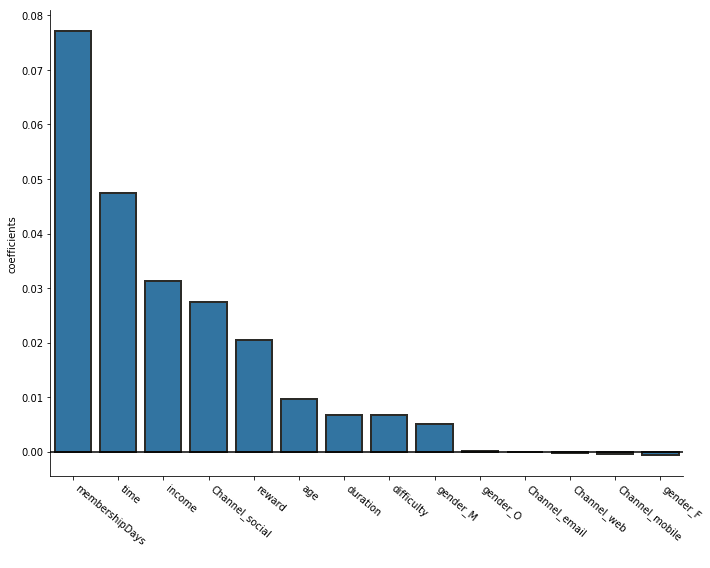

In [133]:
# Plot the distribution of offer response
plt.figure(figsize=[10,8])

ax1 = plt.subplot(111)
# ax1.set_frame_on(True)
ax1.spines['left'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
sns.barplot(x = ee.features, y= ee.coefficients,  color = bcolor, linewidth = 2,  edgecolor=["#2b2b28", "#2b2b28", "#2b2b28", 
                                                                                           "#2b2b28", "#2b2b28", "#2b2b28", 
                                                                                           "#2b2b28", "#2b2b28","#2b2b28", "#2b2b28", "#2b2b28", 
                                                                                           "#2b2b28", "#2b2b28", "#2b2b28", 
                                                                                          "#2b2b28"])
                                                                                           
plt.xlabel(" ")
plt.axhline(y=0.00, color='black', linestyle='-')
plt.xticks(rotation=-40,ha="left")
# plt.title("User Attributes")
plt.tight_layout()
plt.show()

# E. Deployment

## 1. Summary report

Find the summary report on this blog [link](https://medium.com/@okigbookey/starbucks-data-scientist-a9455d67a1cc) 

### Github repository 
Github repository at this [link](https://github.com/jocoder22/Starbucks_Datascience)

## 2. Conclusion(s)
From this analysis is it reasonable to make the following conclusions:
* The typical Starbucks mobile app user is a middle-aged male - baby-boomers - in the middle-class income category. From a business perspective, marketing and product designs should target middle-class hard-working American baby-boomer!
* Discount offers had the highest mobile app users response rate with a 30% viewing rate and a 62% completion rate. From a business and marketing perspective, these viewers should be marketed to complete the Discount offer.
* Membership, income, and perceived rewards are the strongest inducers of response by these users. From a business and marketing perspective, Starbucks customers should encourage to sign up for the mobile app.